In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from afqinsight import AFQDataset
from afqinsight.nn.utils import prep_pytorch_data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import afqinsight.augmentation as aug




/Users/samchou/miniconda3/envs/afq_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps'

In [3]:
dataset = AFQDataset.from_study('hbn')
torch_dataset, train_loader, test_loader, val_loader = prep_pytorch_data(dataset,batch_size=64)  
gt_shape = torch_dataset[0][1].size()[0]
sequence_length = torch_dataset[0][0].size()[0]  # 48
in_channels = torch_dataset[0][0].size()[1]  # 100


File /Users/samchou/.cache/afq-insight/hbn/subjects.tsv exists.
File /Users/samchou/.cache/afq-insight/hbn/nodes.csv exists.


/Users/samchou/miniconda3/envs/afq_new/lib/python3.11/site-packages/afqinsight/transform.py:144: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  features = interpolated.stack(["subjectID", "tractID", "metric"]).unstack(


In [4]:
print(f"Number of subjects: {len(dataset)}")
print(f"len of each dataset", len(train_loader.dataset), len(test_loader.dataset), len(val_loader.dataset))
print(f"shape of data", train_loader.dataset[0][0].shape, train_loader.dataset[0][1].shape)
print(f"one channel of a tract", train_loader.dataset[0][0][0][0].shape)

Number of subjects: 1867
len of each dataset 1194 374 299
shape of data torch.Size([48, 100]) torch.Size([3])
one channel of a tract torch.Size([])


In [5]:
class Encoder(nn.Module):
    def __init__(self, input_shape, latent_dims):
        super(Encoder, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(input_shape, 2400)
        self.linear2 = nn.Linear(2400, 1200)
        self.linear3 = nn.Linear(1200, 600)
        self.linear4 = nn.Linear(600, latent_dims)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.activation(x)
        x = self.linear4(x)
        return x


In [6]:
class VariationalEncoder(nn.Module):
    def __init__(self, input_shape, latent_dims, dropout):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(input_shape, 500)
        self.linear2 = nn.Linear(500, latent_dims)
        self.linear3 = nn.Linear(500, latent_dims)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device) 
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [7]:
class VE_one_tract(nn.Module):
    def __init__(self, input_shape, latent_dims, dropout):
        super(VE_one_tract, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.linear1 = nn.Linear(input_shape, 50)
        self.linear2 = nn.Linear(50, latent_dims)
        self.linear3 = nn.Linear(50, latent_dims)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0
    
    def forward(self, x):
        # print("input shape", x.shape)
        x = torch.flatten(x, start_dim=1)
        # print("flattened shape", x.shape)
        x = self.linear1(x)
        # print("linear1 shape", x.shape)
        x = self.activation(x)
        x = self.dropout(x)
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

# class VE_one_tract(nn.Module):
#     def __init__(self, input_shape, latent_dims, dropout):
#         super(VE_one_tract, self).__init__()
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#         # Compute flattened input size
#         self.num_tracts, self.sequence_length = input_shape
#         self.input_dim = self.num_tracts * self.sequence_length

#         # Define layers
#         self.linear1 = nn.Linear(self.input_dim, 50)
#         self.linear2 = nn.Linear(50, latent_dims)  # Outputting mean
#         self.linear3 = nn.Linear(50, latent_dims)  # Outputting log variance
#         self.dropout = nn.Dropout(dropout)
#         self.activation = nn.ReLU()

#         # Standard normal distribution
#         self.N = torch.distributions.Normal(0, 1)
#         self.N.loc = self.N.loc.to(self.device)
#         self.N.scale = self.N.scale.to(self.device)

#         # KL divergence placeholder
#         self.kl = 0

#     def forward(self, x):
#         x = x.view(x.size(0), -1)  # Shape: (batch_size, num_tracts * sequence_length)

#         # Pass through layers
#         x = self.linear1(x)  # Shape: (batch_size, 50)
#         x = self.activation(x)
#         x = self.dropout(x)

#         # Compute mean and log variance
#         mu = self.linear2(x)  # Shape: (batch_size, latent_dims)
#         log_var = self.linear3(x)  # Shape: (batch_size, latent_dims)
#         sigma = torch.exp(0.5 * log_var)  # Convert log variance to standard deviation

#         # Sample latent vector z
#         z = mu + sigma * self.N.sample(mu.shape).to(self.device)  # Reparameterization trick

#         # Compute KL divergence
#         self.kl = 0.5 * torch.sum(sigma**2 + mu**2 - 1 - log_var)

#         return z


In [8]:
class Decoder_one_tract(nn.Module):
    def __init__(self, input_shape, latent_dims):
        super(Decoder_one_tract, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 50)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(50, input_shape)
        # self.batch_norm = nn.BatchNorm1d(50)
        # self.batch_norm2 = nn.BatchNorm1d(100)
        # self.linear3 = nn.Linear(100, input_shape)
  
    def forward(self, z):
        batch_size = z.size(0)
        x = self.linear1(z)
        x = self.relu(x)
        # x = self.batch_norm(x)  .
        x = self.linear2(x)
        # x = self.relu(x)
        # x = self.batch_norm2(x)
        # x = self.linear3(x)
        return x.view(batch_size, -1)
# class Decoder_one_tract(nn.Module):
#     def __init__(self, input_shape, latent_dims):
#         super(Decoder_one_tract, self).__init__()
#         self.linear1 = nn.Linear(latent_dims, 50)
#         self.relu = nn.ReLU()
#         self.linear2 = nn.Linear(50, input_shape)  # input_shape = num_tracts * sequence_length
#         self.num_tracts = input_shape[0]  # num_tracts
#         self.sequence_length = input_shape[1]  # sequence_length

#     def forward(self, z):
#         batch_size = z.size(0)
#         x = self.linear1(z)
#         x = self.relu(x)
#         x = self.linear2(x)
#         return x.view(batch_size, self.num_tracts, self.sequence_length)  # Reshape to (batch_size, num_tracts, sequence_length)


In [9]:
class Decoder(nn.Module):
    def __init__(self, input_shape, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 600)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(600, 1200)
        self.linear3 = nn.Linear(1200, 2400)
        self.linear4 = nn.Linear(2400, input_shape)
    def forward(self, z):
        batch_size = z.size(0)
        x = self.linear1(z)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        return x.view((batch_size, 48, 100))

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, input_shape, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_shape, latent_dims)
        self.decoder = Decoder(input_shape, latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [11]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_shape, latent_dims, dropout):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(input_shape, latent_dims, dropout=dropout)
        self.decoder = Decoder(input_shape, latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
class VAE_one_tract(nn.Module):
    def __init__(self, input_shape, latent_dims, dropout):
        super(VAE_one_tract, self).__init__()
        self.encoder = VE_one_tract(input_shape, latent_dims, dropout=dropout)
        self.decoder = Decoder_one_tract(input_shape, latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [12]:
def reconstruction_loss(x, x_hat, kl_div=0.0, reduction="sum"):
    """
    Compute the reconstruction loss (MSE) and optionally add a KL term.
    
    Parameters
    ----------
    x : torch.Tensor
        Original input tensor.
    x_hat : torch.Tensor
        Reconstructed output from the autoencoder.
    kl_div : float
        KL divergence term (VAE only). Defaults to 0 for a standard autoencoder.
    reduction : str
        Reduction mode: "sum" or "mean". Defaults to "sum".
    
    Returns
    -------
    torch.Tensor
        Scalar loss value.
    """
    # e.g. use MSE loss
    recon_loss = F.mse_loss(x_hat, x, reduction=reduction)
    l1_loss = F.l1_loss(x_hat, x, reduction=reduction)
    total_loss = recon_loss + kl_div
    return total_loss

In [13]:
def random_type_indices(batch_size, num_types):
    return np.random.choice(num_types, size=batch_size)[1]

def get_random_elements(array):
    batch_size = array.shape[0]
    num_types = array.shape[1]
    # Generate random type indices for each batch element
    type_indices = np.random.randint(0, num_types, size=batch_size)
    # Create batch indices array
    batch_indices = np.arange(batch_size)
    # Index using both arrays
    return array[batch_indices, type_indices]

In [14]:
def train_first_tract(self, data, epochs=20, lr=0.001, sigma=0.02):
    opt = torch.optim.Adam(self.parameters(), lr=lr)

    for epoch in range(epochs):
        running_loss = 0
        items = 0
        for x, _ in data:  # x shape: (batch_size, 48, 100)
            batch_size = x.size(0)  # 64

            # Select only the first tract for each sample
            tract_data = x[:, 0, :].to(torch.float32).to(device)  # Shape: (batch_size, 100)

            # Apply jitter augmentation to tract data
            # tract_data = tract_data.to(torch.float32).numpy()  
            # tract_data = aug.magnitude_warp(tract_data, sigma=sigma, knot=4)  
            # tract_data = aug.jitter(tract_data, sigma=sigma) 
            
            # tract_data = torch.tensor(tract_data, dtype=torch.float32).to(device)  # Convert back to PyTorch tensor

            # Forward pass
            opt.zero_grad()
            x_hat = self(tract_data).to(device)

            # Calculate loss
            loss = reconstruction_loss(tract_data, x_hat, kl_div=0, reduction="sum")

            # Backward pass
            items += tract_data.size(0)
            running_loss += loss.item()
            loss.backward()
            opt.step()

        print(f"Epoch {epoch+1}, Loss: {running_loss/items:.2f}")

    return self


In [15]:
def random_tract_selection(x, num_selected_tracts):
    """
    Randomly select a subset of tracts (channels) from the input data.

    Parameters
    ----------
    x : numpy.ndarray
        Data with shape `(batch, num_tracts, length)`.

    num_selected_tracts : int
        Number of tracts to randomly select.

    Returns
    -------
    numpy.ndarray
        Data with shape `(batch, num_selected_tracts, length)`.
    """
    batch_size, num_tracts, length = x.shape
    ret = np.zeros((batch_size, num_selected_tracts, length), dtype=x.dtype)
    for i in range(batch_size):
        selected_indices = np.random.choice(num_tracts, num_selected_tracts, replace=False)
        ret[i] = x[i, selected_indices, :]
    return ret


In [16]:
def random_flip(tract_data):
    if np.random.rand() > 0.5:
        return torch.flip(tract_data, dims=[-1])
    return tract_data

def segment_swap(batch):
    bs, num_tracts, seq_len = batch.shape
    swap_mask = torch.rand(bs) < 0.3
    
    for i in torch.where(swap_mask)[0]:
        j = np.random.randint(0, bs)
        seg_len = np.random.randint(5, 20) 
        start = np.random.randint(0, seq_len-seg_len)
        batch[i,:,start:start+seg_len] = batch[j,:,start:start+seg_len]
    
    return batch

def add_spikes(data, intensity=0.2, spike_prob=0.05):
    spikes = torch.zeros_like(data)
    spike_mask = torch.rand_like(data) < spike_prob
    spikes[spike_mask] = intensity * torch.randn_like(data[spike_mask])
    return data + spikes

def multi_res_augment(data):
    original = data
    downsampled = F.avg_pool1d(data, kernel_size=3)  
    return 0.7*original + 0.3*downsampled

def simulate_mri_noise(data, snr_range=(3, 10)):
    snr = np.random.uniform(*snr_range)
    noise_power = 1/(snr**2)
    real = data + torch.sqrt(noise_power/2)*torch.randn_like(data)
    imag = torch.sqrt(noise_power/2)*torch.randn_like(data)
    return torch.sqrt(real**2 + imag**2)

def interpolate_tracts(batch, alpha=0.3):
    mixed = batch[:-1] * (1-alpha) + batch[1:] * alpha
    return torch.cat([batch, mixed], dim=0)

def random_masking(data, max_mask_ratio=0.4):
    seq_len = data.shape[-1]
    mask_len = int(seq_len * np.random.uniform(0.1, max_mask_ratio))
    start = np.random.randint(0, seq_len - mask_len)
    data[..., start:start+mask_len] = 0
    return data

def full_augment_pipeline(batch):
    batch = random_flip(batch)
    batch = segment_swap(batch)
    batch = add_spikes(batch)
    batch = multi_res_augment(batch)
    batch = simulate_mri_noise(batch)
    batch = random_masking(batch)
    return batch

aug_config = {
    'flip_prob': 0.5,
    'spike_prob': 0.3,
    'mask_prob': 0.4,
    'swap_prob': 0.25,
    'base_noise': 0.02
}

In [17]:
def random_train_multiple_tracts_test(self, data, epochs=20, lr=0.001, num_selected_tracts=5, 
                               sigma=0.02, jaggedness_factor=0.5):
    opt = torch.optim.Adam(self.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)

    
    aug_params = {
        'spike_intensity': 0.1 * jaggedness_factor,
        'spike_prob': 0.02 * jaggedness_factor,
        'mask_max_ratio': 0.2 * jaggedness_factor,
        'noise_scale': 0.02 * jaggedness_factor,
        'swap_prob': 0.15 * jaggedness_factor,
        'original_mix': 1.0 - 0.4 * jaggedness_factor  
    }

    for epoch in range(epochs):
        running_loss = 0
        items = 0
        for x, _ in data:
            x = x.to(device)
            batch_size = x.size(0)
            num_tracts = x.size(1)

            selected_tracts = []
            for _ in range(num_selected_tracts):
                tract_indices = np.random.randint(0, num_tracts, size=batch_size)
                batch_indices = np.arange(batch_size)
                selected_tracts.append(x[batch_indices, tract_indices, :])
            
            tract_data = torch.stack(selected_tracts, dim=1)

            original_data = tract_data.clone()

            tract_data = tract_data.to(torch.float32).cpu().numpy()
            tract_data = aug.magnitude_warp(tract_data, sigma=sigma * jaggedness_factor, knot=4)
            tract_data = aug.jitter(tract_data, sigma=sigma * jaggedness_factor)
            tract_data = torch.tensor(tract_data, dtype=torch.float32).to(device)

            # randomly flip tracts
            if torch.rand(1) < 0.4:  
                tract_data = torch.flip(tract_data, dims=[-1])

            #adding random spikes
            if torch.rand(1) < aug_params['spike_prob']:
                spike_mask = torch.rand_like(tract_data) < (0.01 + 0.02*jaggedness_factor)
                tract_data += spike_mask.float() * aug_params['spike_intensity'] * torch.randn_like(tract_data)

            # randomly mask contiguous segments
            if torch.rand(1) < 0.3:  
                mask_length = int(tract_data.shape[-1] * np.random.uniform(0.05, aug_params['mask_max_ratio']))
                start_idx = np.random.randint(0, tract_data.shape[-1] - mask_length)
                tract_data[..., start_idx:start_idx+mask_length] = 0

            # swap random segments between samples in batch
            if torch.rand(1) < aug_params['swap_prob']:
                swap_indices = torch.randperm(batch_size)
                segment_length = np.random.randint(3, 8) 
                start = np.random.randint(0, 100 - segment_length)
                tract_data[:, :, start:start+segment_length] = tract_data[swap_indices, :, start:start+segment_length]

            original_data = original_data.to(device)
            tract_data = aug_params['original_mix'] * original_data + (1 - aug_params['original_mix']) * tract_data

            tract_data += aug_params['noise_scale'] * torch.randn_like(tract_data)

            tract_data = tract_data.view(-1, 100).to(device)

            opt.zero_grad()
            x_hat = self(tract_data)
            loss = reconstruction_loss(tract_data, x_hat, kl_div=0, reduction="sum")
            
            items += tract_data.size(0)
            running_loss += loss.item()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)
            
            opt.step()
        scheduler.step(running_loss/items)

        print(f"Epoch {epoch+1}, Loss: {running_loss/items:.2f}")

    return self

In [18]:
def random_train_multiple_tracts(self, data, epochs=20, lr=0.001, num_selected_tracts=5, sigma=0.02):
    opt = torch.optim.Adam(self.parameters(), lr=lr)

    for epoch in range(epochs):
        running_loss = 0
        items = 0
        for x, _ in data:  # x shape: (batch_size, 48, 100)
            batch_size = x.size(0)  # 64
            num_tracts = x.size(1)  # 48

            selected_tracts = []  # By the end, will have shape (batch_size, num_selected_tracts, 100)
            for _ in range(num_selected_tracts):
                tract_indices = np.random.randint(0, num_tracts, size=batch_size)
                batch_indices = np.arange(batch_size)
                # Selects specific samples from the batch
                selected_tracts.append(x[batch_indices, tract_indices, :])  # Shape: (batch_size, 100)
            
            # Stack selected tracts and reshape for processing
            tract_data = torch.stack(selected_tracts, dim=1)  # Shape: (batch_size, num_selected_tracts, 100)
            # print("tract_data", tract_data.shape)
            
            # print("tract_data_part_1", tract_data.dtype)

            # tract_data = aug.permutation(tract_data, num_selected_tracts, seg_mode="random")  # Apply permutation augmentation

            # Apply jitter augmentation to tract data
            tract_data = tract_data.to(torch.float32).numpy()  
            # tract_data = aug.permutation(tract_data, num_selected_tracts)
            tract_data = aug.magnitude_warp(tract_data, sigma=sigma, knot=4)  
            tract_data = aug.jitter(tract_data, sigma=sigma) 
            
            tract_data = torch.tensor(tract_data, dtype=torch.float32).to(device)  # Convert back to PyTorch tensor

            # print("tract_data_part_2", tract_data.shape)
            # # Flatten the data for the model
            tract_data = tract_data.view(-1, 100).to(device)  # shape is now (batch_size * num_selected_tracts, 100)

            # print("tract_data_part_3", tract_data.shape)
            # Forward pass
            opt.zero_grad()
            x_hat = self(tract_data)

            # Calculate lossa
            loss = reconstruction_loss(tract_data, x_hat, kl_div=0, reduction="sum") #+ 0.5 * self.encoder.kl

            # Backward pass
            items += tract_data.size(0)
            running_loss += loss.item()
            loss.backward()
            opt.step()

        print(f"Epoch {epoch+1}, Loss: {running_loss/items:.2f}")

    return self


In [19]:
def random_train_multiple_tracts_experiment(
    self, train_data, val_data, epochs=20, lr=0.001, num_selected_tracts=5, sigma=0.03
):
    opt = torch.optim.Adam(self.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)
    train_rmse_per_epoch = []
    val_rmse_per_epoch = []
    best_val_loss = float('inf')  # Track the best (lowest) validation RMSE overall

    for epoch in range(epochs):
        # Training
        self.train()
        running_loss = 0
        running_rmse = 0
        items = 0

        for x, _ in train_data:  # x shape: (batch_size, 48, 100)
            batch_size = x.size(0)
            # For simplicity, using only the first tract in training
            tract_data = x[:, 0, :]

            # Apply jitter augmentation
            tract_data = tract_data.to(torch.float32).numpy()
            tract_data = aug.jitter(tract_data, sigma=sigma)
            tract_data = torch.tensor(tract_data, dtype=torch.float32).to(device)

            # Forward pass
            opt.zero_grad()
            x_hat = self(tract_data)

            # Calculate loss
            loss = reconstruction_loss(tract_data, x_hat, kl_div=0, reduction="sum")
            # Compute RMSE for the batch
            batch_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))

            # Backward pass
            loss.backward()
            opt.step()

            items += tract_data.size(0)
            running_loss += loss.item()
            running_rmse += batch_rmse.item() * tract_data.size(0)  # Weighted sum

        scheduler.step(running_loss / items)
        avg_train_rmse = running_rmse / items
        train_rmse_per_epoch.append(avg_train_rmse)

        # Validation
        self.eval()
        val_rmse = 0
        val_items = 0

        with torch.no_grad():
            for x, _ in val_data:
                batch_size = x.size(0)
                # For simplicity, using the first tract in validation as well
                tract_data = x[:, 0, :]

                # Apply jitter augmentation
                tract_data = tract_data.to(torch.float32).numpy()
                tract_data = aug.jitter(tract_data, sigma=sigma)
                tract_data = torch.tensor(tract_data, dtype=torch.float32).to(device)

                # Forward pass
                x_hat = self(tract_data)

                # Compute RMSE for the batch
                batch_val_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))

                val_items += tract_data.size(0)
                val_rmse += batch_val_rmse.item() * tract_data.size(0)

        avg_val_rmse = val_rmse / val_items
        val_rmse_per_epoch.append(avg_val_rmse)

        # Update best validation loss if improved
        if avg_val_rmse < best_val_loss:
            best_val_loss = avg_val_rmse

        print(
            f"Epoch {epoch+1}, Train RMSE: {avg_train_rmse:.4f}, Val RMSE: {avg_val_rmse:.4f}"
        )

    return train_rmse_per_epoch, val_rmse_per_epoch, best_val_loss


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

# Define the Autoencoder class with a variable latent dimension
class Autoencoder(nn.Module):
    def __init__(self, input_dim=100, latent_dim=10):
        super(Autoencoder, self).__init__()

        # Encoder: Compress input to latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, latent_dim),
            nn.ReLU()
        )

        # Decoder: Reconstruct back to original input_dim
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 100),
            nn.ReLU(),
            nn.Linear(100, input_dim),
            nn.Sigmoid()  # Output range [0,1] assuming normalized input
        )

    def forward(self, x):
        z = self.encoder(x)  # Encoding step
        x_hat = self.decoder(z)  # Decoding step
        return x_hat

def train_multiple_latent_dimensions(train_data, val_data, epochs=100, lr=0.001, sigma=0.03):
    latent_dims = list(range(10, 101, 10))  # [10, 20, ..., 100]
    results = []

    for latent_dim in latent_dims:
        print(f"Training Autoencoder with Latent Dimension: {latent_dim}")

        # Initialize a new autoencoder for each latent dimension
        model = Autoencoder(input_dim=100, latent_dim=latent_dim).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)

        train_rmse_per_epoch = []
        val_rmse_per_epoch = []
        best_val_loss = float('inf')  # Track the best (lowest) validation RMSE
        best_model_state = None     # Save the best model state

        for epoch in range(epochs):
            # Training
            model.train()
            running_loss = 0
            running_rmse = 0
            items = 0

            for x, _ in train_data:  # x shape: (batch_size, 48, 100)
                batch_size = x.size(0)
                tract_data = x[:, 0, :].to(device)  # Shape: (batch_size, 100)

                opt.zero_grad()
                x_hat = model(tract_data)

                loss = reconstruction_loss(tract_data, x_hat, kl_div=0, reduction="sum")
                batch_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))

                loss.backward()
                opt.step()

                items += tract_data.size(0)
                running_loss += loss.item()
                running_rmse += batch_rmse.item() * tract_data.size(0)  # Weighted sum

            scheduler.step(running_loss / items)
            avg_train_rmse = running_rmse / items
            train_rmse_per_epoch.append(avg_train_rmse)

            # Validation
            model.eval()
            val_rmse = 0
            val_items = 0

            with torch.no_grad():
                for x, _ in val_data:
                    tract_data = x[:, 0, :].to(device)
                    x_hat = model(tract_data)
                    batch_val_rmse = torch.sqrt(F.mse_loss(tract_data, x_hat, reduction="mean"))
                    val_items += tract_data.size(0)
                    val_rmse += batch_val_rmse.item() * tract_data.size(0)

            avg_val_rmse = val_rmse / val_items
            val_rmse_per_epoch.append(avg_val_rmse)

            # Check and save the best model state if current validation loss is lower
            if avg_val_rmse < best_val_loss:
                best_val_loss = avg_val_rmse
                best_model_state = model.state_dict()

            print(f"Latent Dim {latent_dim} - Epoch {epoch+1}, Train RMSE: {avg_train_rmse:.4f}, Val RMSE: {avg_val_rmse:.4f}")

        results.append({
            "latent_dim": latent_dim,
            "train_rmse_per_epoch": train_rmse_per_epoch,
            "val_rmse_per_epoch": val_rmse_per_epoch,
            "best_val_loss": best_val_loss,
            "best_model_state": best_model_state  # Optional: Save checkpoint for later use
        })

    return results


In [21]:
def random_train_one_tract(self, data, epochs=20, lr=0.001):
    opt = torch.optim.Adam(self.parameters(), lr=lr)

    for epoch in range(epochs):
        running_loss = 0
        items = 0
        for x, _ in data:  # x shape: (batch_size, 48, 100)
            batch_size = x.size(0)
            num_tracts = x.size(1)

            # Randomly select one tract per batch element
            tract_indices = np.random.randint(0, num_tracts, size=batch_size)
            batch_indices = np.arange(batch_size)

            # Extract the randomly chosen tracts
            tract_data = x[batch_indices, tract_indices, :]  # Shape: [batch_size, 100]

            # Add a channel dimension for consistency
            tract_data = tract_data.unsqueeze(1)  # Shape: [batch_size, 1, 100]

            # Move data to device
            tract_data = tract_data.to(device)

            # Forward pass
            opt.zero_grad()
            x_hat = self(tract_data)

            # Calculate loss
            loss = reconstruction_loss(tract_data, x_hat, kl_div=0, reduction="sum")

            # Backward pass
            items += tract_data.size(0)
            running_loss += loss.item()
            loss.backward()
            opt.step()

        print(f"Epoch {epoch+1}, Loss: {running_loss/items:.2f}")

    return self


In [22]:
def simple_train(self, data, epochs=20, lr=0.001):
    opt = torch.optim.Adam(self.parameters(), lr=lr)
    for epoch in range(epochs):
        running_loss = 0
        items = 0
        for x, _ in data:
            print(x.shape)
            x = x.to(device)

            opt.zero_grad()
            x_hat = self(x)

            # No KL term for a plain autoencoder
            loss = reconstruction_loss(x, x_hat, kl_div=0, reduction="sum")

            items += x.size(0)
            running_loss += loss.item()
            loss.backward()
            opt.step()

        print(f"Epoch {epoch+1}, Loss: {running_loss/items:.2f}")
    return self


In [23]:
def detailed_train(model, train_loader, val_loader, patience=10, lr_patience=3, epochs=5, lr=1e-3, use_lr_scheduler=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if use_lr_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=lr_patience, verbose=True)
    loss_fn = nn.MSELoss()
    num_no_improve=0
    best_val_loss = 10**10

    for epoch in range(epochs):
        model.train()  # set to train mode
        epoch_loss = 0.0
        num_items = 0
        batch_sz = 32
        batch_per_epoch = 100
        for x, _ in train_loader:
            x = x.to(device)

            x_hat = model(x)
            loss = loss_fn(x_hat, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_items += x.size(0)
        avg_loss = epoch_loss / num_items

        print(f"Epoch {epoch+1}/{epochs}, Loss = {avg_loss:.6f}, lr = {optimizer.param_groups[0]['lr']}")

        # Validation loss
        model.eval()
        batch_per_epoch_val = 10
        val_loss = 0.0
        num_items = 0
        with torch.no_grad():
            for x, _ in val_loader:
                
                x = x.to(device)
                x_hat = model(x)
                loss = loss_fn(x_hat, x).item()
                val_loss += loss
                num_items += x.size(0)  

        val_loss /= num_items
        if use_lr_scheduler:
            scheduler.step(val_loss)

        if val_loss > best_val_loss:
            num_no_improve+=1
        else:
            num_no_improve=0
            best_val_loss = val_loss
    
        if num_no_improve != 0:
            print(f"Validation Loss = {val_loss:.6f}, No improvement for {num_no_improve} epochs")
        else:
            print(f"Validation Loss = {val_loss:.6f}")
        
        if num_no_improve == patience:
            print("Early stopping")
            break

    return model

In [24]:
print(in_channels)

100


In [25]:
results = train_multiple_latent_dimensions(train_loader, val_loader)

Training Autoencoder with Latent Dimension: 10
Latent Dim 10 - Epoch 1, Train RMSE: 0.0772, Val RMSE: 0.0624
Latent Dim 10 - Epoch 2, Train RMSE: 0.0545, Val RMSE: 0.0525
Latent Dim 10 - Epoch 3, Train RMSE: 0.0509, Val RMSE: 0.0514
Latent Dim 10 - Epoch 4, Train RMSE: 0.0503, Val RMSE: 0.0508
Latent Dim 10 - Epoch 5, Train RMSE: 0.0497, Val RMSE: 0.0502
Latent Dim 10 - Epoch 6, Train RMSE: 0.0490, Val RMSE: 0.0497
Latent Dim 10 - Epoch 7, Train RMSE: 0.0484, Val RMSE: 0.0488
Latent Dim 10 - Epoch 8, Train RMSE: 0.0475, Val RMSE: 0.0474
Latent Dim 10 - Epoch 9, Train RMSE: 0.0463, Val RMSE: 0.0464
Latent Dim 10 - Epoch 10, Train RMSE: 0.0452, Val RMSE: 0.0455
Latent Dim 10 - Epoch 11, Train RMSE: 0.0430, Val RMSE: 0.0424
Latent Dim 10 - Epoch 12, Train RMSE: 0.0409, Val RMSE: 0.0401
Latent Dim 10 - Epoch 13, Train RMSE: 0.0389, Val RMSE: 0.0380
Latent Dim 10 - Epoch 14, Train RMSE: 0.0375, Val RMSE: 0.0368
Latent Dim 10 - Epoch 15, Train RMSE: 0.0364, Val RMSE: 0.0360
Latent Dim 10 - E

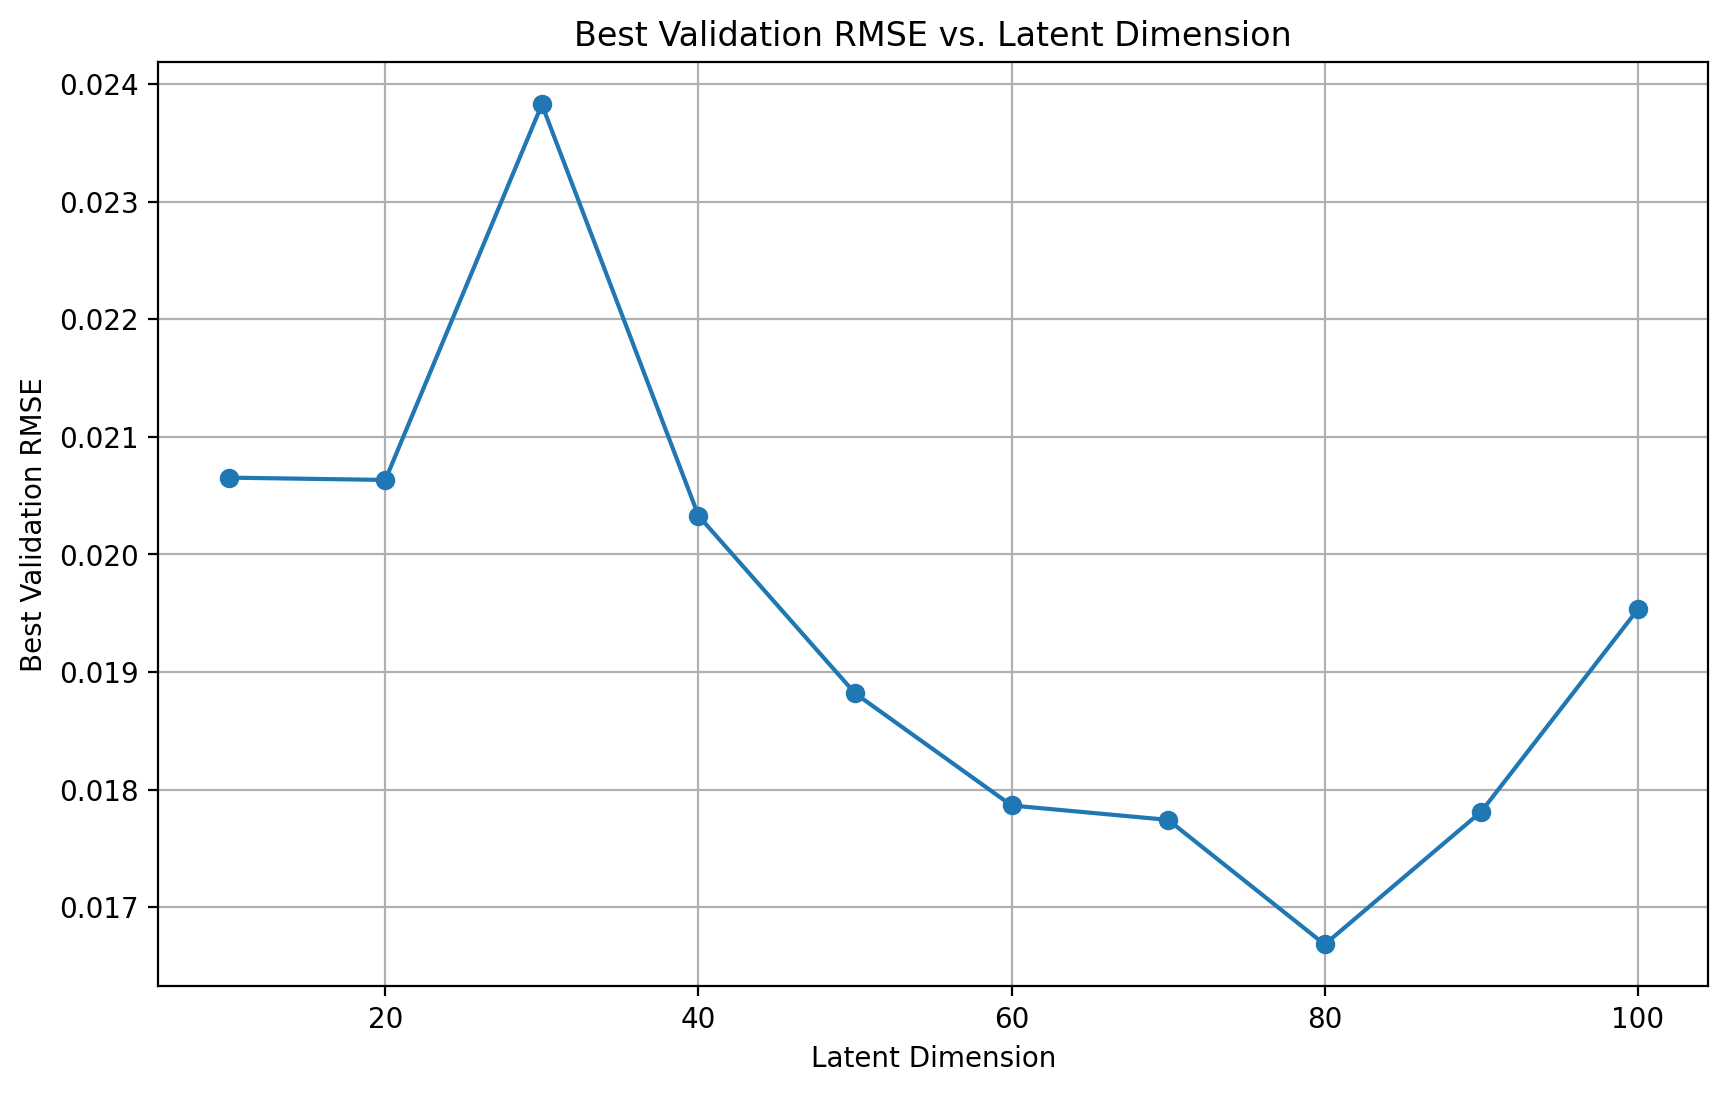

In [26]:
latent_dims = [result["latent_dim"] for result in results]
best_val_losses = [result["best_val_loss"] for result in results]

plt.figure(figsize=(10, 6))
plt.plot(latent_dims, best_val_losses, marker='o')
plt.xlabel("Latent Dimension")
plt.ylabel("Best Validation RMSE")
plt.title("Best Validation RMSE vs. Latent Dimension")
plt.grid()
plt.show()

In [614]:
print(results)

[{'latent_dim': 10, 'train_rmse_per_epoch': [0.08143155829640888, 0.06085743886766522, 0.05839081240234463, 0.057556794142004236, 0.05686536413840513, 0.05622158769886298, 0.055366498940753774, 0.0542565636536484, 0.052992078165213265, 0.05205350832224292, 0.0504723622259283, 0.049394258770661136, 0.04819860678771433, 0.04753580597077982, 0.047196456797458416, 0.04675476405913107, 0.04654083583797242, 0.046165265454918496, 0.04583427181445574, 0.04552028092931663, 0.0454393331728988, 0.04482389168448784, 0.044440518197302444, 0.0439850119015879, 0.04378364970236767, 0.04343025217228998, 0.04309782377714089, 0.04270252487442801, 0.04223981246327236, 0.04217643980904041, 0.04174450215208071, 0.04118453397398418, 0.04108827934917094, 0.040403338439350754, 0.04005847116261471, 0.03992968105665803, 0.03952834209180757, 0.0393324056125466, 0.03909676630592825, 0.03906870420579135, 0.038947839658064656, 0.03892372094306914, 0.038704014490896735, 0.038591793920826074, 0.03821440344330054, 0.03

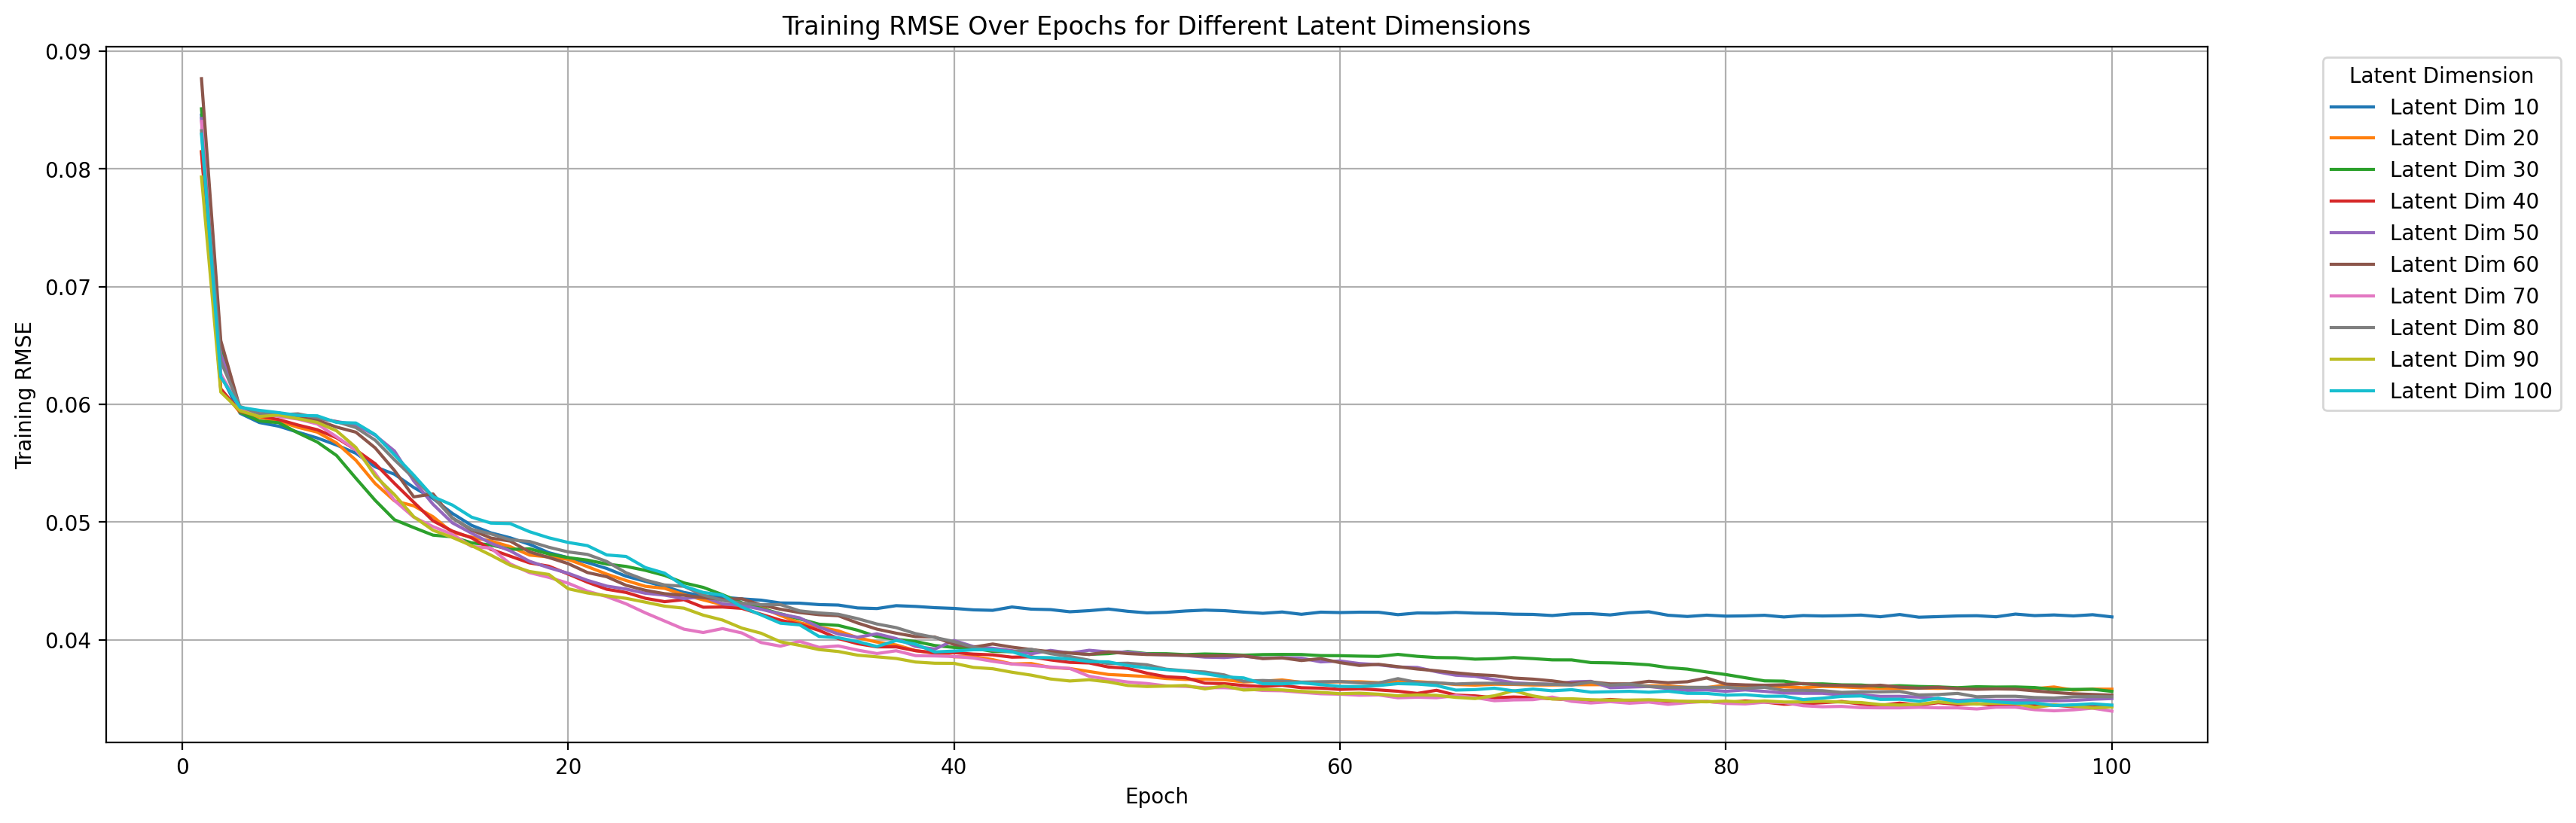

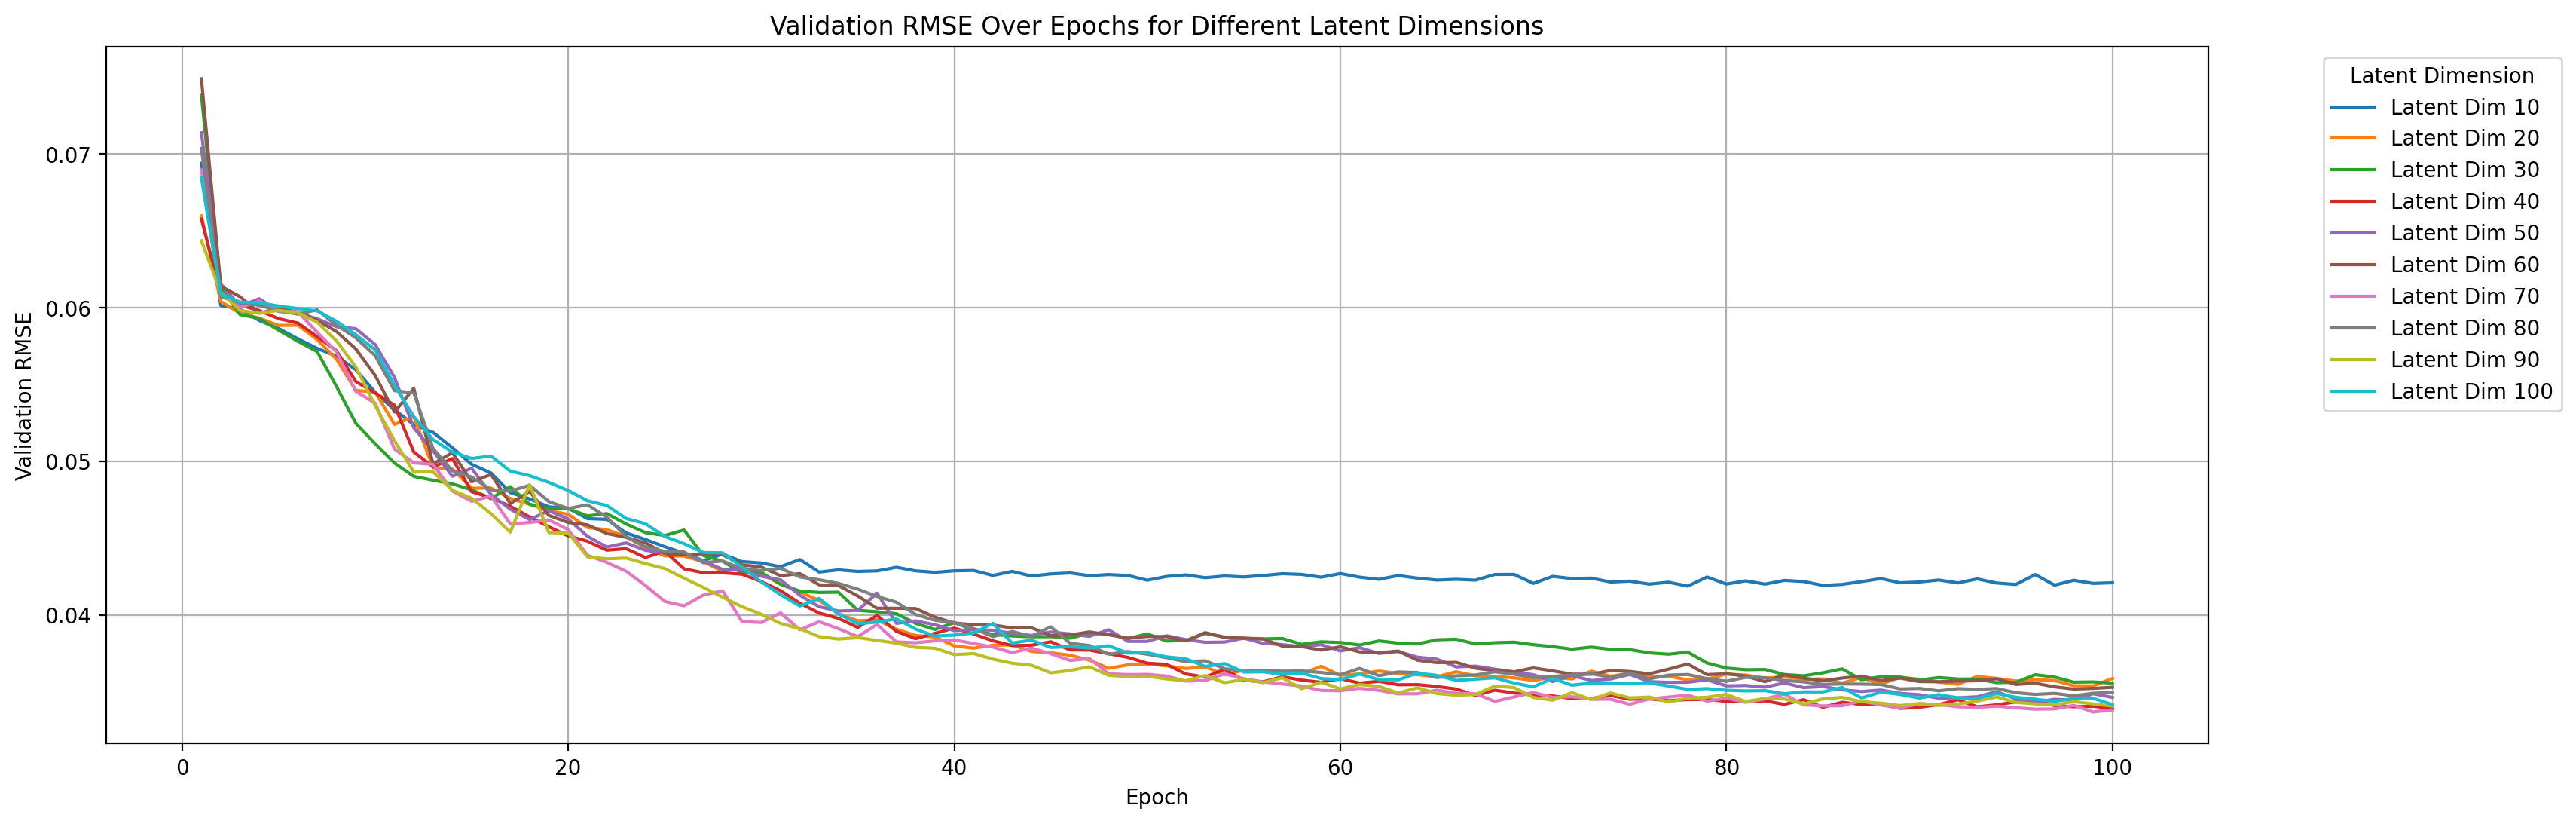

In [615]:
import matplotlib.pyplot as plt

latent_dims = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

#plot 1, train rmse vs epoch
plt.figure(figsize=(18, 6))
for result in results: 
    plt.plot(
        range(1, len(result["train_rmse_per_epoch"]) + 1),
        result["train_rmse_per_epoch"],
        label=f"Latent Dim {result['latent_dim']}",  
    )
plt.xlabel("Epoch")
plt.ylabel("Training RMSE")
plt.title("Training RMSE Over Epochs for Different Latent Dimensions")
plt.legend(title="Latent Dimension", bbox_to_anchor=(1.05, 1), loc="upper left")  
plt.grid()
plt.show()

#plot 1, val rmse vs epoch
plt.figure(figsize=(18, 6))
for result in results:  
    plt.plot(
        range(1, len(result["val_rmse_per_epoch"]) + 1),
        result["val_rmse_per_epoch"],
        label=f"Latent Dim {result['latent_dim']}", 
    )
plt.xlabel("Epoch")
plt.ylabel("Validation RMSE")
plt.title("Validation RMSE Over Epochs for Different Latent Dimensions")
plt.legend(title="Latent Dimension", bbox_to_anchor=(1.05, 1), loc="upper left")  
plt.grid()
plt.show()



Training with dropout = 0
Epoch 1, Train RMSE: 0.4185, Val RMSE: 0.3201
Epoch 2, Train RMSE: 0.2445, Val RMSE: 0.1709
Epoch 3, Train RMSE: 0.1247, Val RMSE: 0.0895
Epoch 4, Train RMSE: 0.0765, Val RMSE: 0.0648
Epoch 5, Train RMSE: 0.0601, Val RMSE: 0.0573
Epoch 6, Train RMSE: 0.0553, Val RMSE: 0.0537
Epoch 7, Train RMSE: 0.0531, Val RMSE: 0.0522
Epoch 8, Train RMSE: 0.0518, Val RMSE: 0.0512
Epoch 9, Train RMSE: 0.0509, Val RMSE: 0.0506
Epoch 10, Train RMSE: 0.0503, Val RMSE: 0.0501
Epoch 11, Train RMSE: 0.0498, Val RMSE: 0.0497
Epoch 12, Train RMSE: 0.0495, Val RMSE: 0.0494
Epoch 13, Train RMSE: 0.0494, Val RMSE: 0.0490
Epoch 14, Train RMSE: 0.0492, Val RMSE: 0.0491
Epoch 15, Train RMSE: 0.0490, Val RMSE: 0.0488
Epoch 16, Train RMSE: 0.0488, Val RMSE: 0.0485
Epoch 17, Train RMSE: 0.0487, Val RMSE: 0.0487
Epoch 18, Train RMSE: 0.0485, Val RMSE: 0.0482
Epoch 19, Train RMSE: 0.0485, Val RMSE: 0.0480
Epoch 20, Train RMSE: 0.0483, Val RMSE: 0.0481
Epoch 21, Train RMSE: 0.0482, Val RMSE: 0.

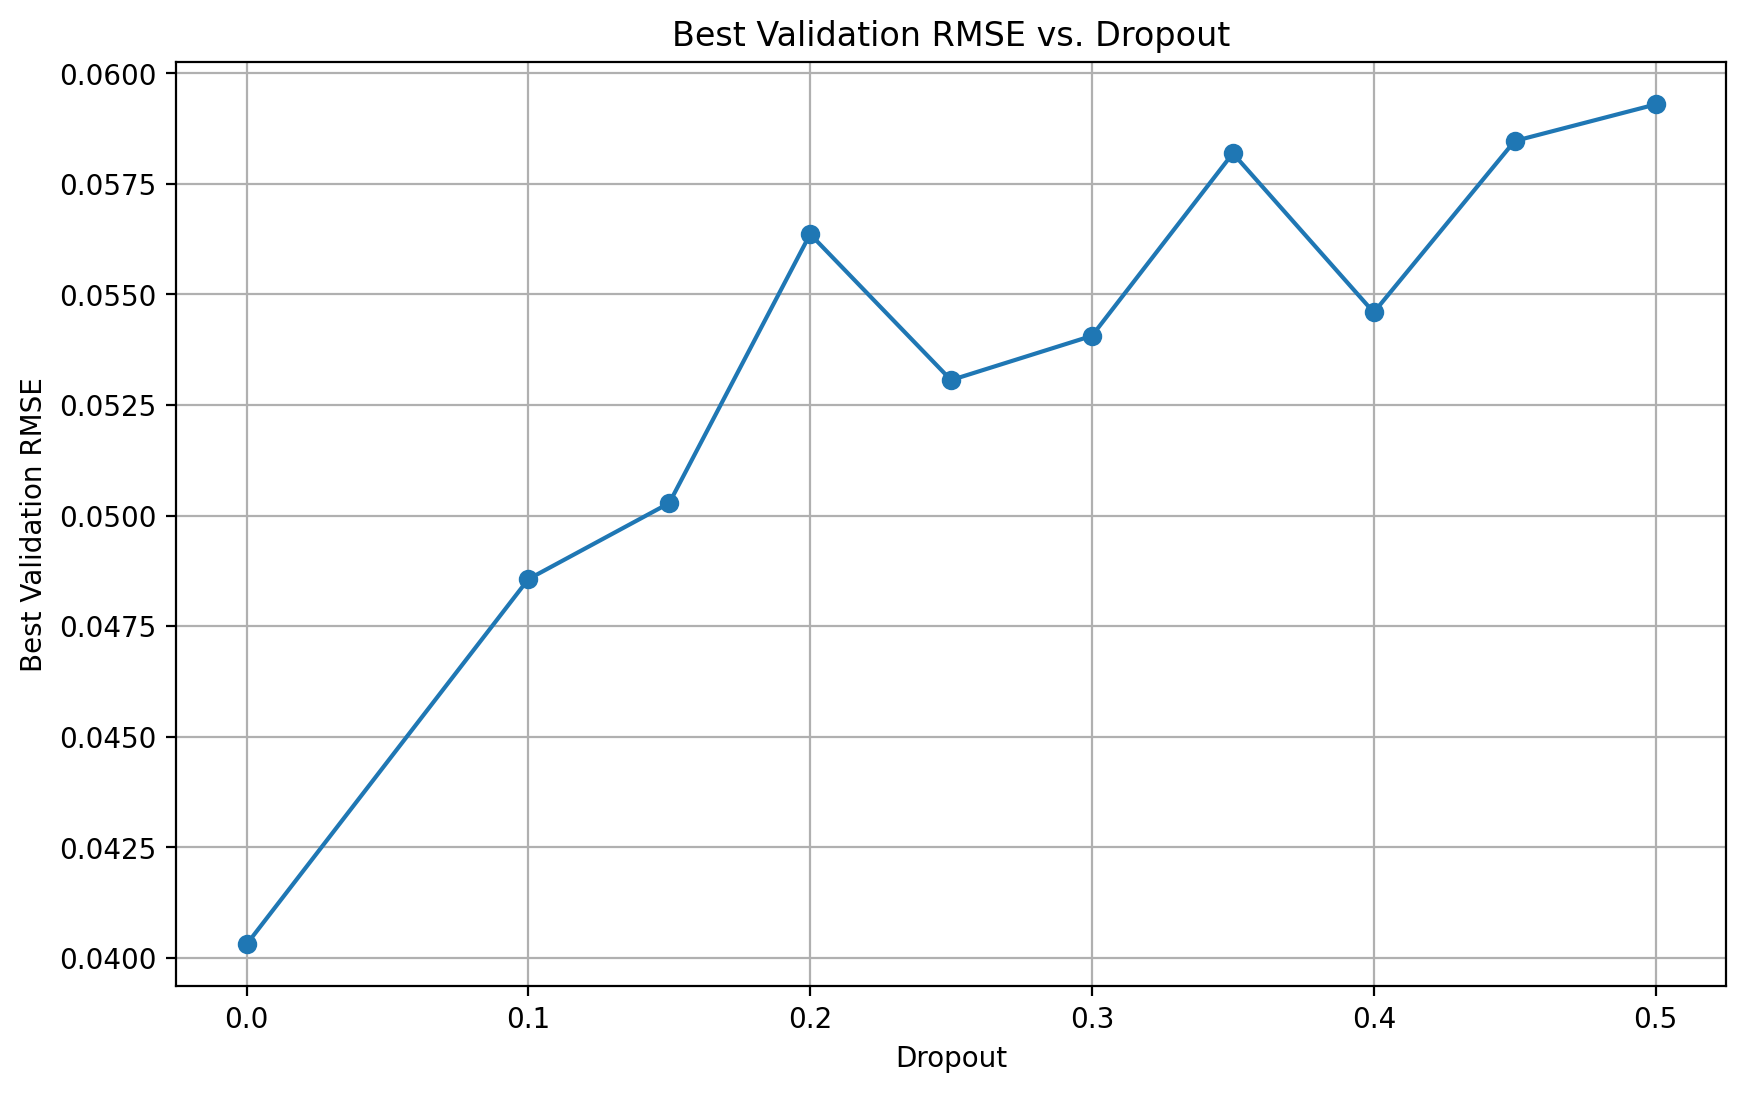

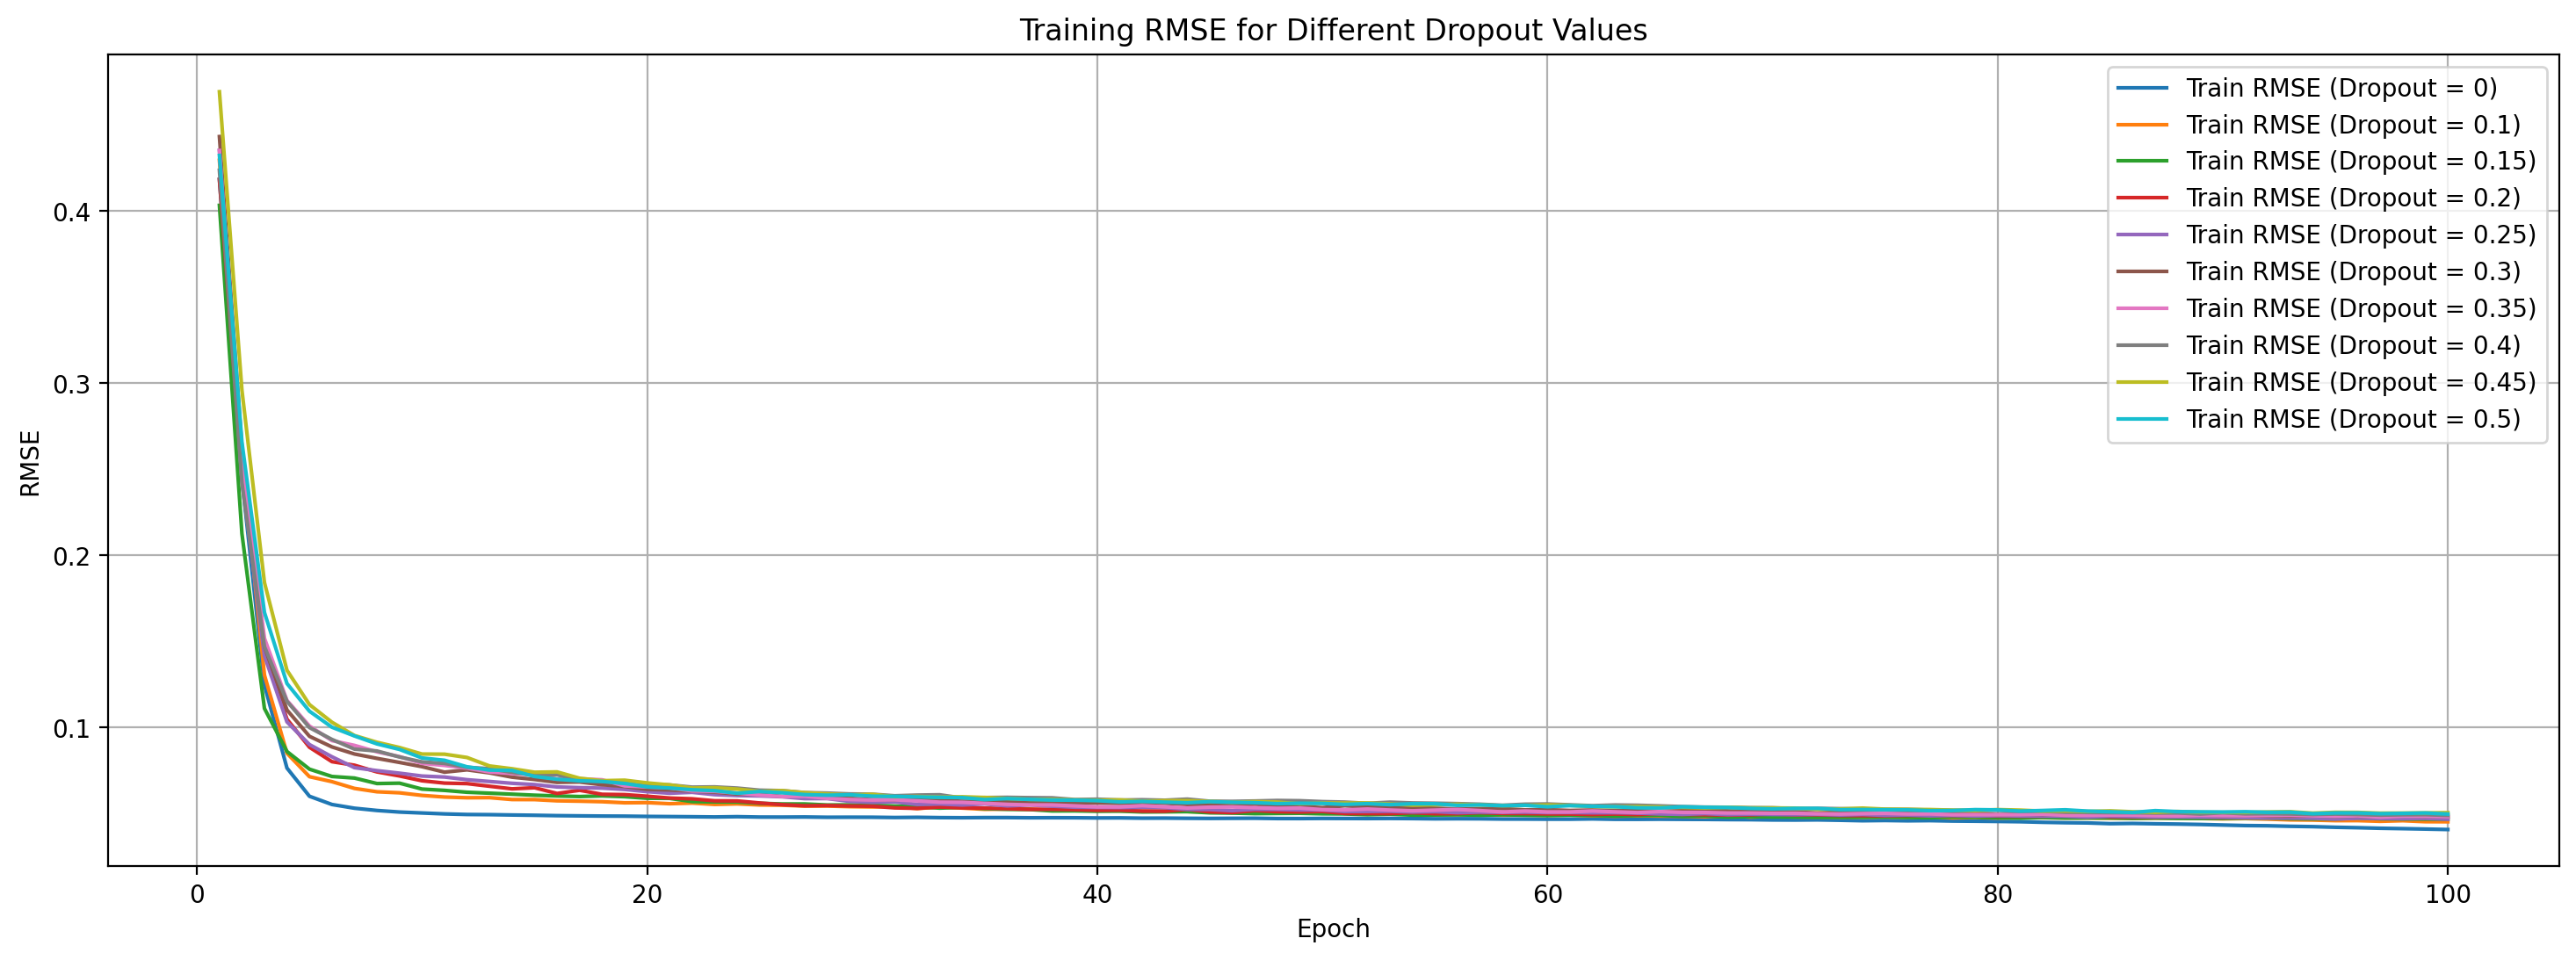

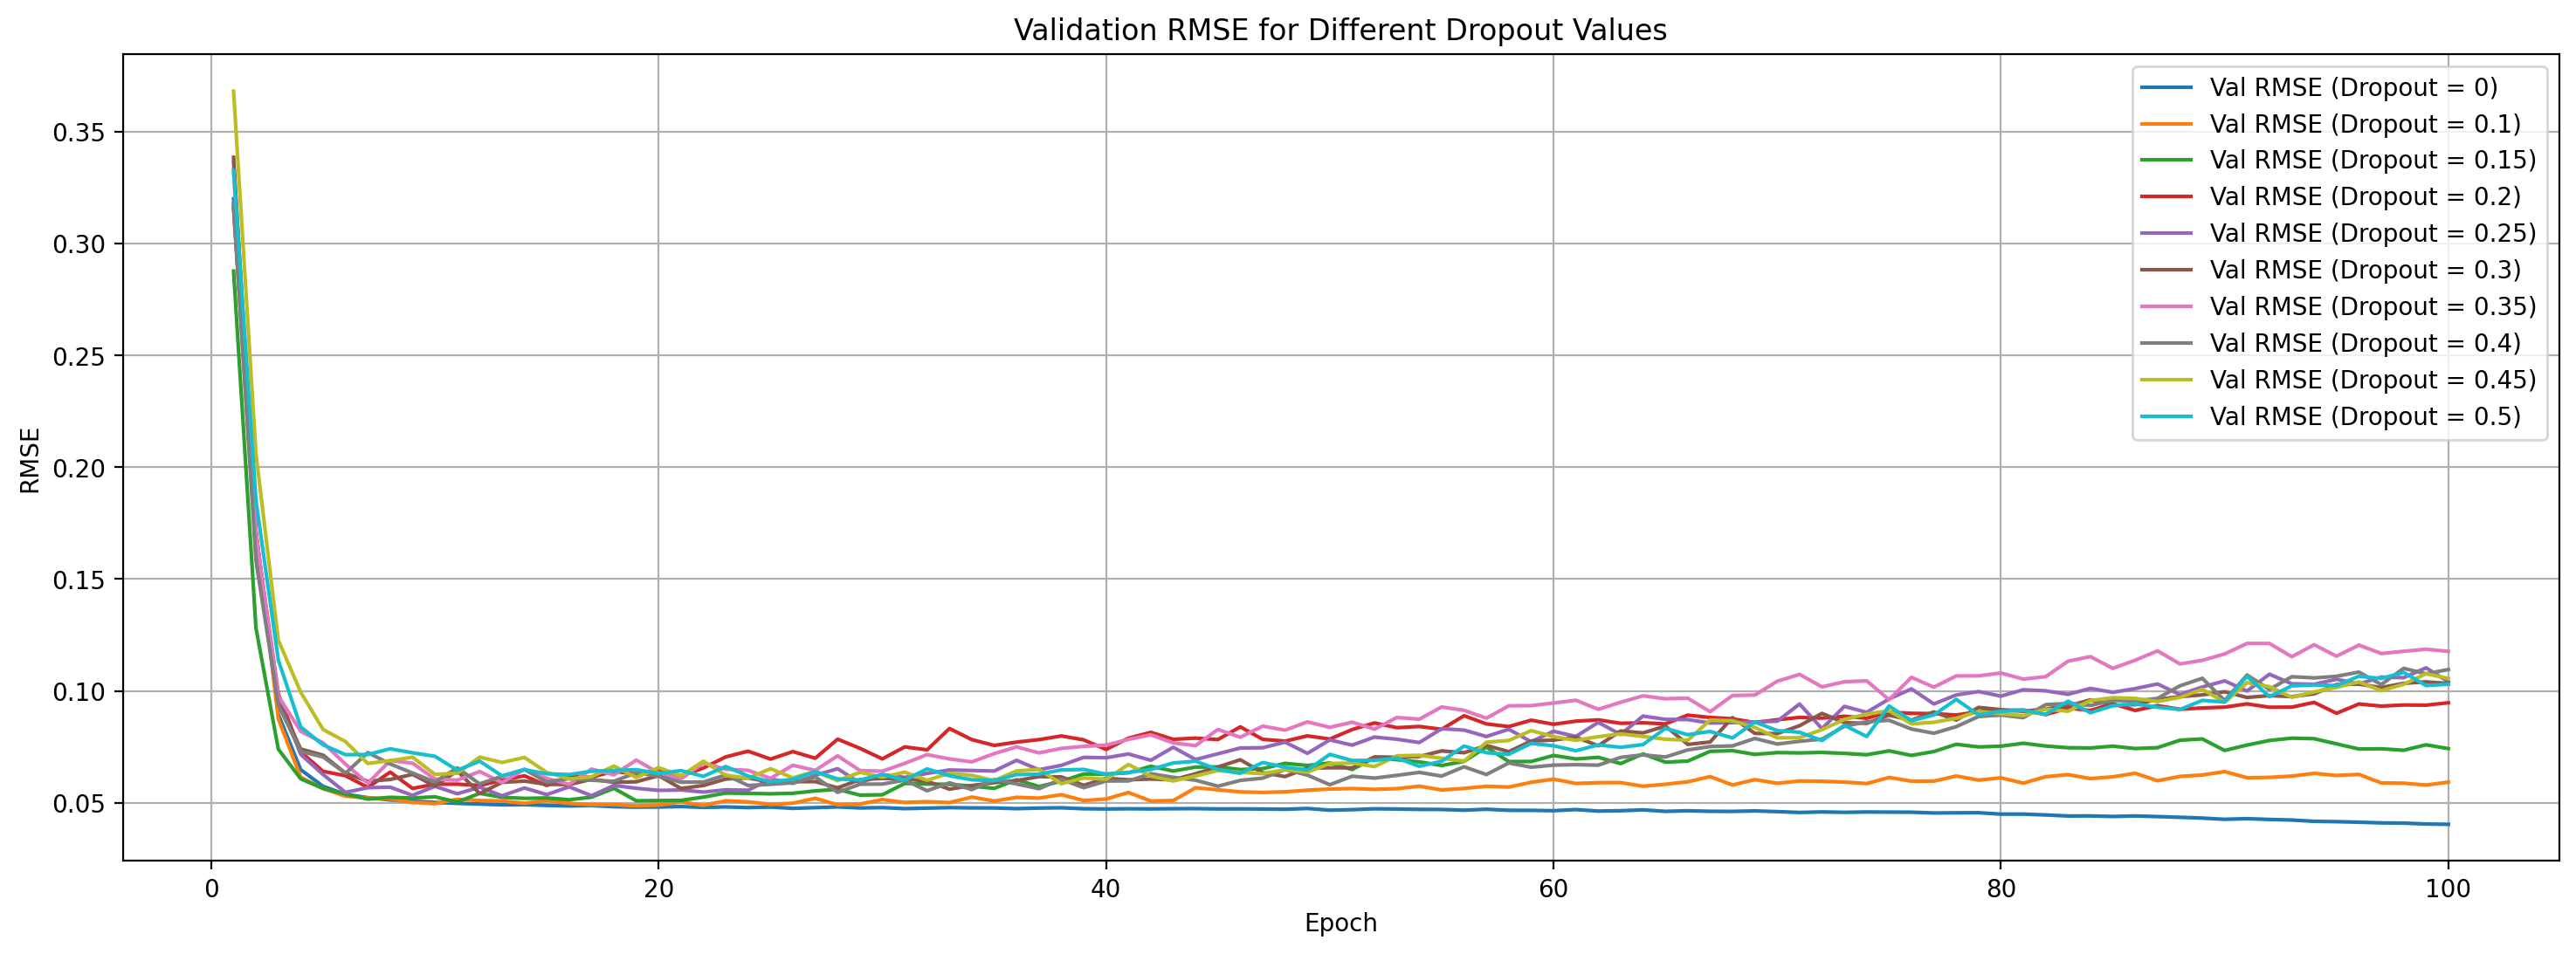

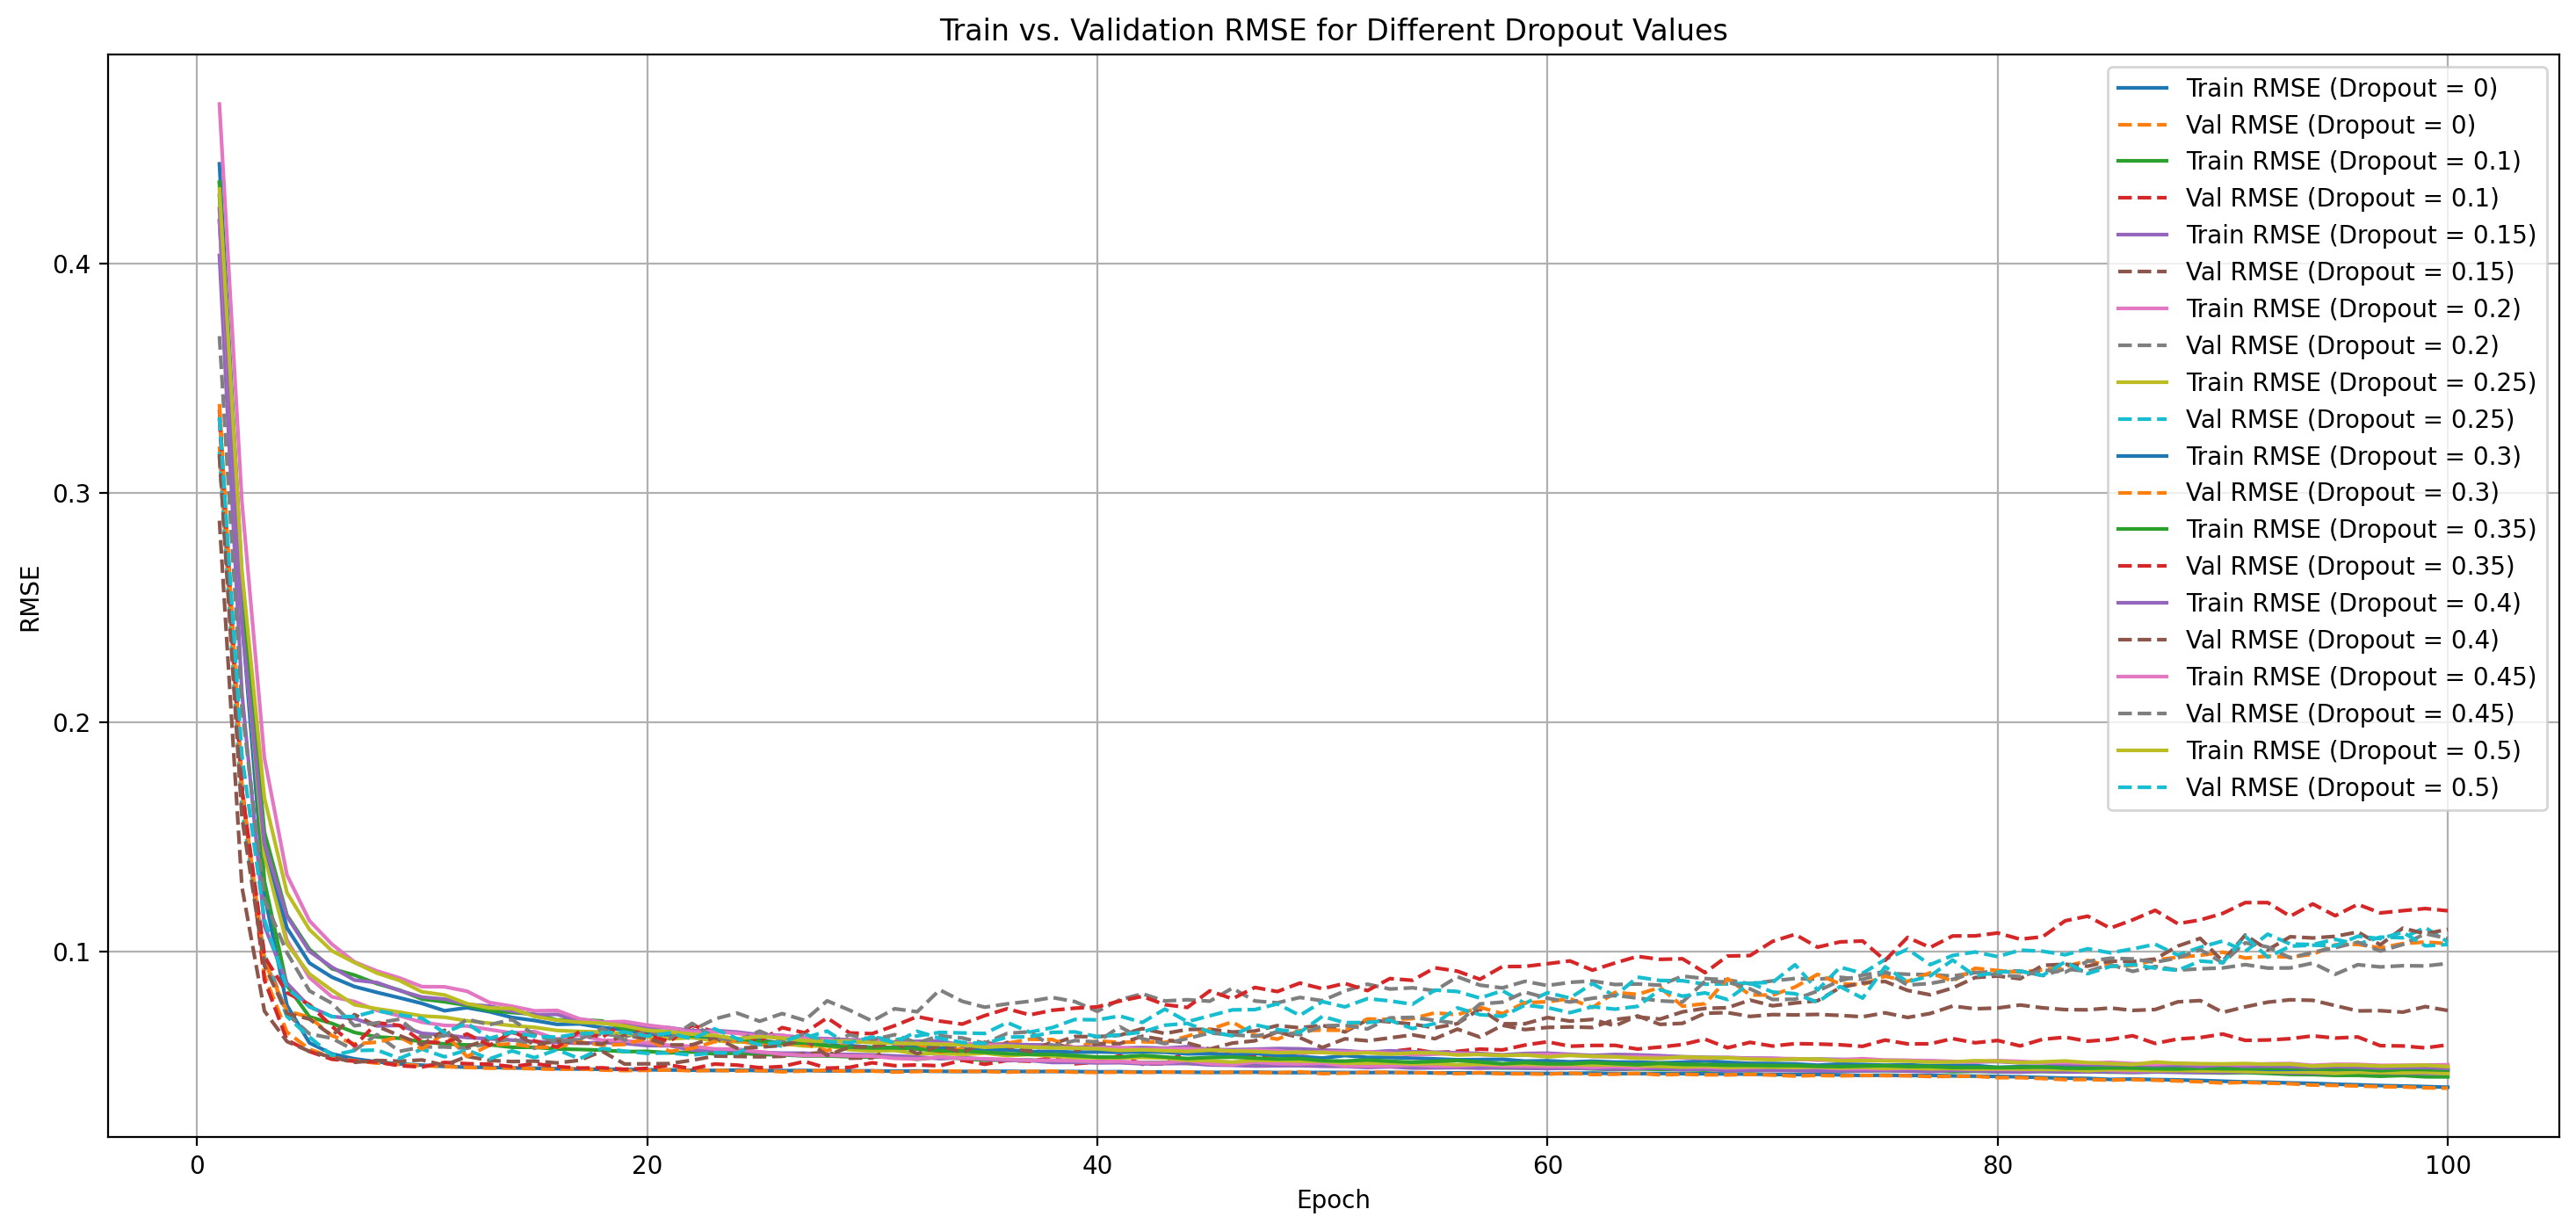

In [32]:
import matplotlib.pyplot as plt


dropout_values = [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
train_rmse_results = {}
val_rmse_results = {}
best_val_results = {}

for dropout in dropout_values:
    print(f"\nTraining with dropout = {dropout}")
    vae_one_tract = VAE_one_tract(in_channels, latent_dims=20, dropout=dropout).to(device)
    train_rmse, val_rmse, best_val_loss = random_train_multiple_tracts_experiment(
        vae_one_tract, train_loader, val_loader, epochs=100, lr=1e-3, num_selected_tracts=8
    )
    train_rmse_results[dropout] = train_rmse
    val_rmse_results[dropout] = val_rmse
    best_val_results[dropout] = best_val_loss

# Plot best validation RMSE for each dropout value
plt.figure(figsize=(10, 6))
dropout_keys = sorted(best_val_results.keys())
best_vals = [best_val_results[d] for d in dropout_keys]
plt.plot(dropout_keys, best_vals, marker='o')
plt.xlabel("Dropout")
plt.ylabel("Best Validation RMSE")
plt.title("Best Validation RMSE vs. Dropout")
plt.grid()
plt.show()

# Plot 1: Training RMSE only
plt.figure(figsize=(18, 6))
for dropout in dropout_values:
    plt.plot(
        range(1, len(train_rmse_results[dropout]) + 1),
        train_rmse_results[dropout],
        label=f"Train RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()

# Plot 2: Validation RMSE only
plt.figure(figsize=(18, 6))
for dropout in dropout_values:
    plt.plot(
        range(1, len(val_rmse_results[dropout]) + 1),
        val_rmse_results[dropout],
        label=f"Val RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Validation RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()

# Plot 3: Both Training and Validation RMSE
plt.figure(figsize=(18, 8))
for dropout in dropout_values:
    plt.plot(
        range(1, len(train_rmse_results[dropout]) + 1),
        train_rmse_results[dropout],
        label=f"Train RMSE (Dropout = {dropout})",
    )
    plt.plot(
        range(1, len(val_rmse_results[dropout]) + 1),
        val_rmse_results[dropout],
        linestyle="--",
        label=f"Val RMSE (Dropout = {dropout})",
    )
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Train vs. Validation RMSE for Different Dropout Values")
plt.legend()
plt.grid()
plt.show()


In [450]:
print(len(train_rmse_results[0]))
print(len(val_rmse_results[0]))

100
100


In [616]:
latent_dims = 100
input_shape = sequence_length * in_channels
dropout = 0.0

# vae = VariationalAutoencoder(input_shape, latent_dims, dropout).to(device) # GPU
# vae = simple_train(vae, train_loader, epochs=100, lr=1e-3)
vae_one_tract = VAE_one_tract(in_channels, 100, dropout=dropout).to(device)
# vae_one_tract = random_train_multiple_tracts(vae_one_tract, train_loader, epochs=100, lr=1e-3, num_selected_tracts=8)
vae_one_tract = train_first_tract(vae_one_tract, train_loader, epochs=100, lr=1e-3, sigma=0.02)
# vae = detailed_train(vae, train_loader, val_loader, epochs = 500, lr=1e-2, use_lr_scheduler=True)


Epoch 1, Loss: 21.50
Epoch 2, Loss: 6.74
Epoch 3, Loss: 1.51
Epoch 4, Loss: 0.47
Epoch 5, Loss: 0.26
Epoch 6, Loss: 0.21
Epoch 7, Loss: 0.18
Epoch 8, Loss: 0.17
Epoch 9, Loss: 0.16
Epoch 10, Loss: 0.16
Epoch 11, Loss: 0.15
Epoch 12, Loss: 0.15
Epoch 13, Loss: 0.15
Epoch 14, Loss: 0.15
Epoch 15, Loss: 0.15
Epoch 16, Loss: 0.14
Epoch 17, Loss: 0.14
Epoch 18, Loss: 0.14
Epoch 19, Loss: 0.14
Epoch 20, Loss: 0.14
Epoch 21, Loss: 0.14
Epoch 22, Loss: 0.14
Epoch 23, Loss: 0.14
Epoch 24, Loss: 0.14
Epoch 25, Loss: 0.14
Epoch 26, Loss: 0.14
Epoch 27, Loss: 0.14
Epoch 28, Loss: 0.14
Epoch 29, Loss: 0.14
Epoch 30, Loss: 0.14
Epoch 31, Loss: 0.14
Epoch 32, Loss: 0.14
Epoch 33, Loss: 0.14
Epoch 34, Loss: 0.14
Epoch 35, Loss: 0.13
Epoch 36, Loss: 0.13
Epoch 37, Loss: 0.13
Epoch 38, Loss: 0.13
Epoch 39, Loss: 0.13
Epoch 40, Loss: 0.13
Epoch 41, Loss: 0.13
Epoch 42, Loss: 0.13
Epoch 43, Loss: 0.13
Epoch 44, Loss: 0.13
Epoch 45, Loss: 0.13
Epoch 46, Loss: 0.13
Epoch 47, Loss: 0.13
Epoch 48, Loss: 0.13


In [617]:
# output = vae.forward(test_loader.dataset[0][0].unsqueeze(0).to(device))
# output2 = vae.forward(test_loader.dataset[1][0].unsqueeze(0).to(device))

print(test_loader.dataset[0][0][0].unsqueeze(0).shape)

output3 = vae_one_tract.forward(test_loader.dataset[0][0][0].unsqueeze(0).to(device))
output4 = vae_one_tract.forward(test_loader.dataset[1][0][0].unsqueeze(0).to(device))

print(output3.size())

torch.Size([1, 100])
torch.Size([1, 100])


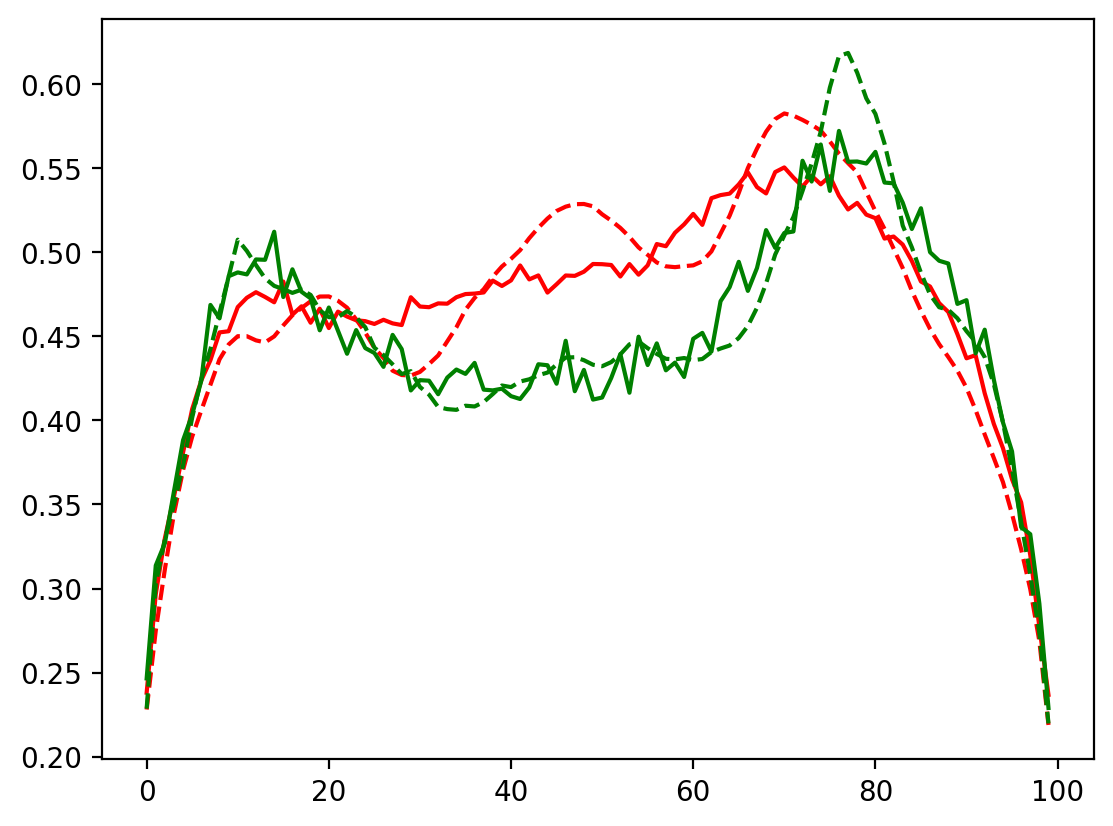

In [618]:
# plt.plot(output.cpu().detach().numpy().flatten()[0:100], color='red')
# plt.plot(dataset.X[0].flatten()[0:100], color='red', linestyle='dashed')
# plt.plot(output2.cpu().detach().numpy().flatten()[0:100], color='green')
# plt.plot(dataset.X[1].flatten()[0:100], color='green', linestyle='dashed')

plt.plot(output3.cpu().detach().numpy().flatten()[0:100], color='red')
# plt.plot(dataset.X[0].flatten()[0:100], color='red', linestyle='dashed')
plt.plot(test_loader.dataset[0][0][0].unsqueeze(0).flatten()[0:100], color='red', linestyle='dashed')
plt.plot(output4.cpu().detach().numpy().flatten()[0:100], color='green')
plt.plot(test_loader.dataset[1][0][0].unsqueeze(0).flatten()[0:100], color='green', linestyle='dashed')
# plt.plot(dataset.X[1].flatten()[0:100], color='green', linestyle='dashed')

In [492]:
def plot_latent(vautoencoder, data_loader, target_index, num_batches=100):
    plt.figure(figsize=(8, 6))
    
    for i, (x, y) in enumerate(data_loader):
        print(x.shape, y.shape)  
        z = vautoencoder.encoder(x.to(device)).to('cpu').detach().numpy()
        print("Latent space shape:", z.shape)  
        
        target = y[:, target_index].to('cpu').numpy()  # Shape: (batch_size,)
        print("Target column:", target.shape)
        
        plt.scatter(z[:, 0], z[:, 1], c=target, cmap='viridis', alpha=0.5)
        
        if i >= num_batches:
            break
    
    plt.colorbar(label=f"Target: {target_index}")
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title(f"Latent Space Visualization (Target Index: {target_index})")
    
    plt.show()



In [493]:
plot_latent(vae, train_loader, 0)

NameError: name 'vae' is not defined

torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torc

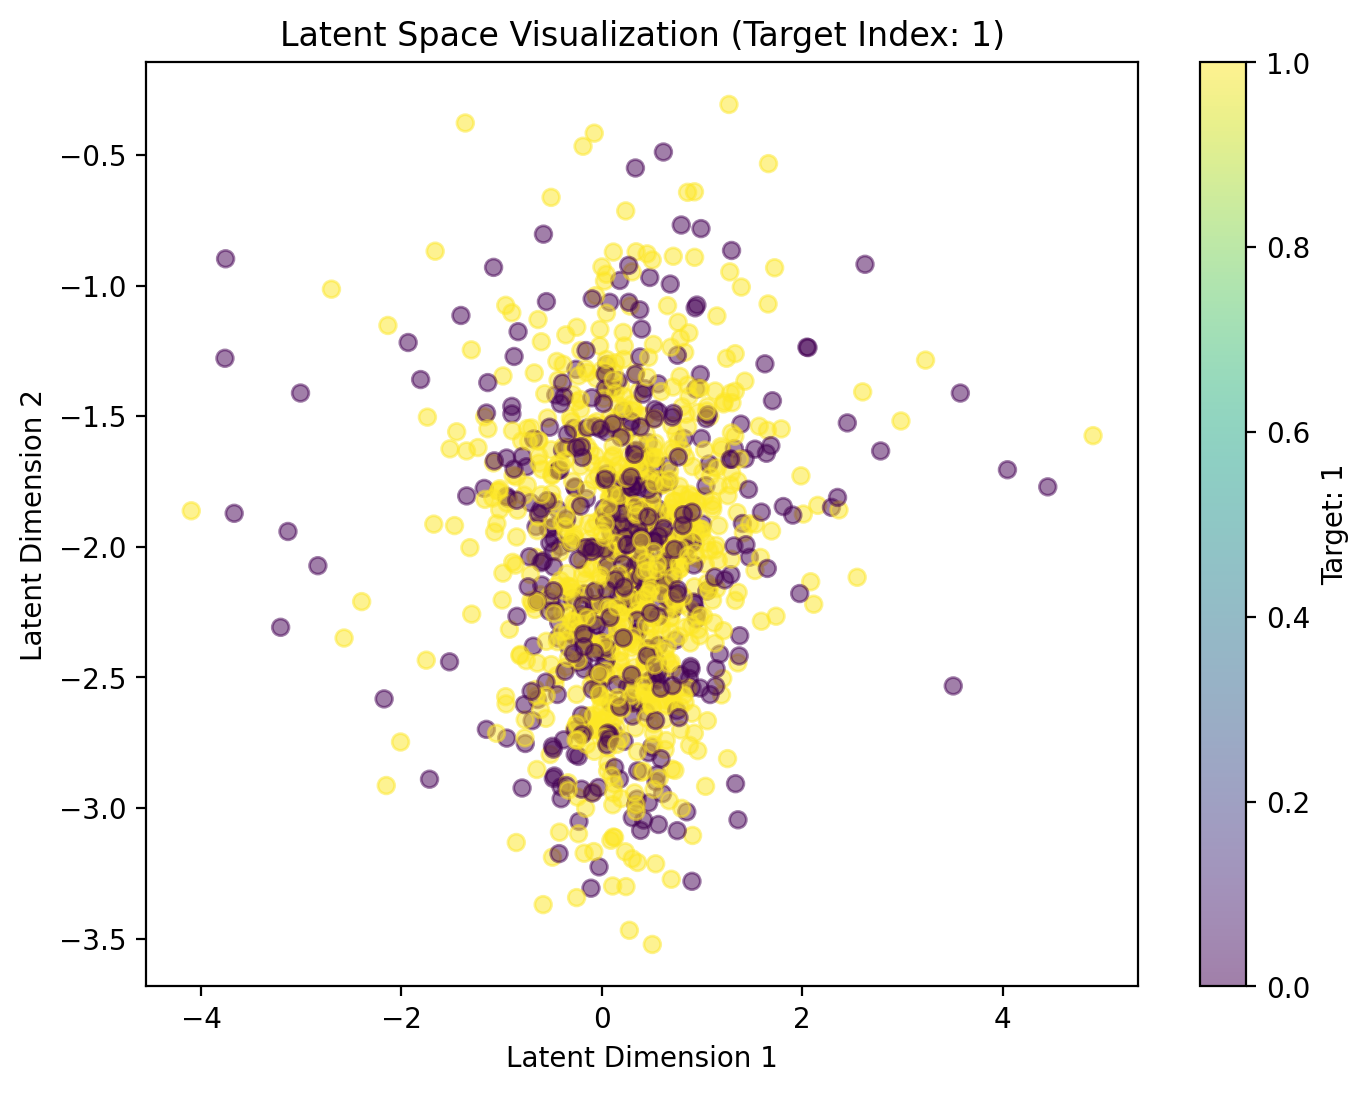

In [ ]:
plot_latent(vae, train_loader, 1)

torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torch.Size([64, 3])
Latent space shape: (64, 100)
Target column: (64,)
torch.Size([64, 48, 100]) torc

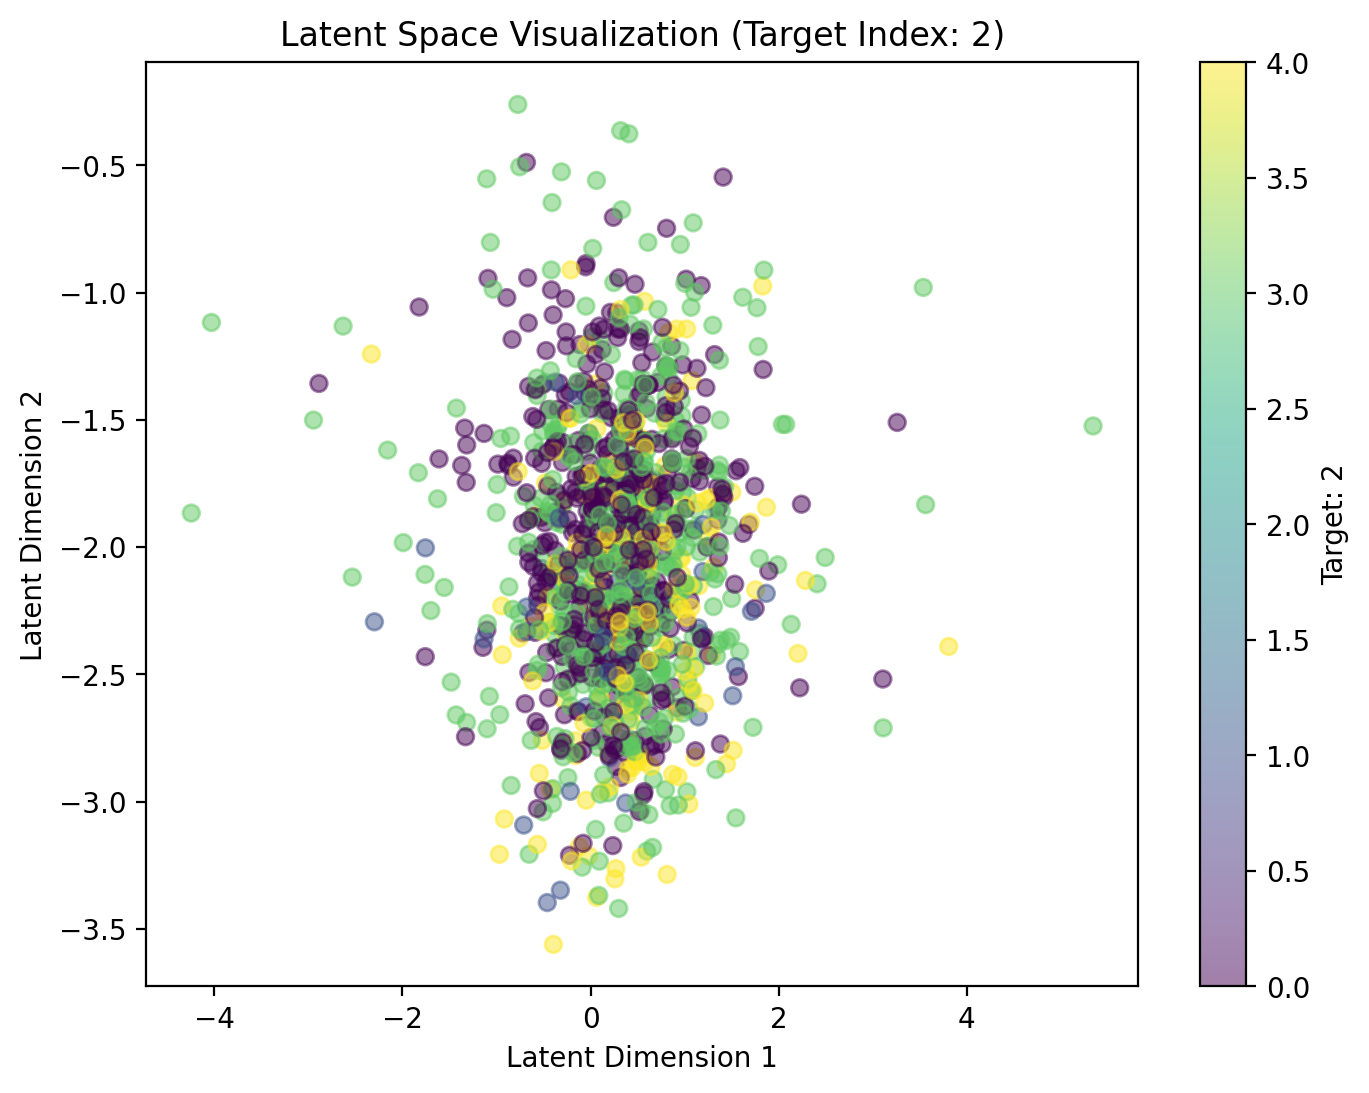

In [ ]:
plot_latent(vae, train_loader, 2)

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    # w = 28
    img = np.zeros((n*48, n*100))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(48, 100).to('cpu').detach().numpy()
            img[(n-1-i)*48:(n-1-i+1)*48, j*100:(j+1)*100] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [ ]:
xhat = plot_reconstructed(vae)

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (1x2 and 100x600)

In [ ]:
plt.plot(xhat[0,0])

TypeError: 'NoneType' object is not subscriptable

: 

: 

In [ ]:
def data_reconstruction(vautoencoder, data_loader, target_index, num_batches=100):    
    for i, (x, y) in enumerate(data_loader):
        print(x.shape, y.shape)  
        z = vautoencoder.encoder(x.to(device)).to('cpu').detach().numpy()
        print(z.shape)
        z = vautoencoder.decoder(z).to('cpu').detach().numpy()
        print(z.shape)
        print("Latent space shape:", z.shape)  

        if i >= num_batches:
            break

        return z



: 

: 

In [ ]:
data_reconstruction(vae, train_loader, 0)

torch.Size([128, 48, 100]) torch.Size([128, 3])
(128, 2)
(128, 2)


TypeError: 'int' object is not callable

: 

: 

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12, feature_indices=(0, 1)):
    plt.figure(figsize=(8, 6))
    for i, y in enumerate(np.linspace(*r1, n)): 
        # print("i", i)
        for j, x in enumerate(np.linspace(*r0, n)):  
            # print("j", j)
            z = torch.Tensor([[x, y]]).to(device)
            
            x_hat = autoencoder.decoder(z).to('cpu').detach().numpy()
            # print("xhat", x_hat.shape)
            
            # feature_x, feature_y = x_hat[feature_indices[0]], x_hat[feature_indices[1]]
            
            # plt.scatter(feature_x, feature_y, color='blue', alpha=0.5)

    return x_hat
    plt.xlabel(f'Feature {feature_indices[0]}')
    plt.ylabel(f'Feature {feature_indices[1]}')
    plt.title("Reconstructed Features Visualization from Latent Space")
    plt.show()


: 

: 